In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [2]:
train_image = pd.read_csv("../dataset/csvTrainImages 13440x1024.csv", header = None)
train_label = pd.read_csv("../dataset/csvTrainLabel 13440x1.csv", header = None)
test_image = pd.read_csv("../dataset/csvTestImages 3360x1024.csv", header = None )
test_label = pd.read_csv("../dataset/csvTestLabel 3360x1.csv", header = None )

In [47]:
# add the lables of the dataset
train_image['label'] = train_label
test_image['label'] = test_label

In [23]:
class ImageDataset(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(32, 32)
        label = self.data.iloc[index, -1] - 1
        
        if self.transform is not None:
            image = self.transform(image)
            
        img = torch.Tensor(rotate(torch.flip(image, (0, 1)), -90, axes=(1,2)))
        
        img = transforms.functional.resize(img, (128,128))
        
        return img, label

def view_data(data: torch.Tensor, label: torch.Tensor, n: int) -> plt.Figure:

    arab_labs = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط' , 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']

    fig, axs = plt.subplots(1, n, figsize=(21, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
        ax.set_title("Label = %s" % (arab_labs[int(label[i_ax].item())]))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig


def view_data_rand(loader: torch.utils.data.DataLoader, n: int = 10) -> plt.Figure:

    rand_data, rand_label = next(iter(loader))

    return view_data(rand_data, rand_label, n)

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_image_dataset = ImageDataset(train_image, transform)

In [96]:
image, label = train_image_dataset.__getitem__(32)
image.size()

torch.Size([1, 128, 128])

In [26]:
loader = DataLoader(train_image_dataset, batch_size= 32, shuffle=True)

rand_data, rand_label = next(iter(loader))
rand_data.shape

torch.Size([32, 1, 128, 128])

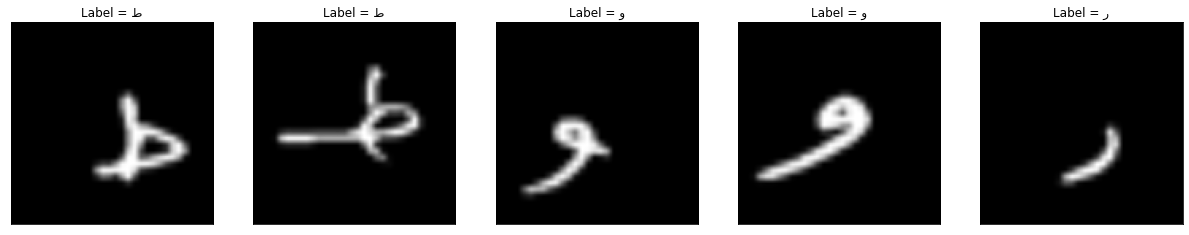

In [27]:
plts = view_data_rand(loader, n=5)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [48]:
class ShabakaNet(nn.Module):
    def __init__(self):
        super(ShabakaNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(256 * 8 * 8, 500)
        self.fc2 = nn.Linear(500, 28)
        
    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [49]:
# Train the model
num_epochs = 10
learning_rate = 0.001
total_step = len(loader)
loss_list = []
acc_list = []
model = ShabakaNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
criterion = nn.CrossEntropyLoss();

In [50]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [100/420], Loss: 1.8633, Accuracy: 37.50%
Epoch [1/10], Step [200/420], Loss: 1.3067, Accuracy: 50.00%
Epoch [1/10], Step [300/420], Loss: 1.2030, Accuracy: 59.38%
Epoch [1/10], Step [400/420], Loss: 0.6954, Accuracy: 71.88%
Epoch [2/10], Step [100/420], Loss: 0.9873, Accuracy: 78.12%
Epoch [2/10], Step [200/420], Loss: 0.5638, Accuracy: 84.38%
Epoch [2/10], Step [300/420], Loss: 0.4335, Accuracy: 84.38%
Epoch [2/10], Step [400/420], Loss: 0.6376, Accuracy: 84.38%
Epoch [3/10], Step [100/420], Loss: 0.3004, Accuracy: 90.62%
Epoch [3/10], Step [200/420], Loss: 0.6823, Accuracy: 75.00%
Epoch [3/10], Step [300/420], Loss: 0.2332, Accuracy: 90.62%
Epoch [3/10], Step [400/420], Loss: 0.3761, Accuracy: 87.50%
Epoch [4/10], Step [100/420], Loss: 0.2498, Accuracy: 90.62%
Epoch [4/10], Step [200/420], Loss: 0.2392, Accuracy: 90.62%
Epoch [4/10], Step [300/420], Loss: 0.5525, Accuracy: 81.25%
Epoch [4/10], Step [400/420], Loss: 0.2719, Accuracy: 90.62%
Epoch [5/10], Step [100/

In [51]:
test_image_dataset = ImageDataset(test_image, transform)
test_loader = DataLoader(test_image_dataset, batch_size= 1, shuffle=False)
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 3360 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
# torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

Test Accuracy of the model on the 3360 test images: 95.11904761904762 %


In [64]:
from PIL import Image

sins = Image.open('SinsPics.png')

to_img = transforms.ToPILImage()
to_norm = transforms.Normalize(mean=(0.5,), std=(0.5,))
to_gray = transforms.Grayscale(num_output_channels=1)
to_tens = transforms.ToTensor()
sins_fin = to_norm(to_gray(to_tens(sins)))

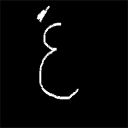

In [120]:
sins

In [119]:
arab_labs = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط' , 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']

with torch.no_grad():

    output = model(torch.unsqueeze(sins_fin, dim=0).to(device))
    _, predicted = torch.max(output.data, 1)
    print(arab_labs[int(predicted.detach())])

غ


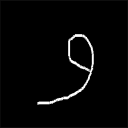

In [121]:
sins2 = Image.open('SinsPics2.png')
sins_fin2 = to_norm(to_gray(to_tens(sins2)))
sins2

In [122]:
with torch.no_grad():

    output = model(torch.unsqueeze(sins_fin2, dim=0).to(device))
    _, predicted = torch.max(output.data, 1)
    print(arab_labs[int(predicted.detach())])

و


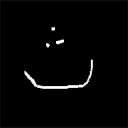

In [123]:
sins3 = Image.open('SinsPics3.png')
sins_fin3 = to_norm(to_gray(to_tens(sins3)))
sins3

In [124]:
with torch.no_grad():

    output = model(torch.unsqueeze(sins_fin3, dim=0).to(device))
    _, predicted = torch.max(output.data, 1)
    print(arab_labs[int(predicted.detach())])

ث


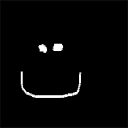

In [125]:
sins4 = Image.open('SinsPics4.png')
sins_fin4 = to_norm(to_gray(to_tens(sins4)))
sins4

In [127]:
with torch.no_grad():

    output = model(torch.unsqueeze(sins_fin4, dim=0).to(device))
    yep, predicted = torch.max(output.data, 1)
    print(arab_labs[int(predicted.detach())])

ت


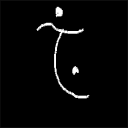

In [137]:
sins5 = Image.open('SinsPics5.png')
sins_fin5 = to_norm(to_gray(to_tens(sins5)))
sins5

In [138]:
with torch.no_grad():

    output = model(torch.unsqueeze(sins_fin5, dim=0).to(device))
    yep, predicted = torch.max(output.data, 1)
    print(arab_labs[int(predicted.detach())])

خ


In [143]:
m = nn.Softmax(dim=1)

out = m(output)
out

tensor([[1.0455e-06, 1.2534e-12, 3.9061e-11, 1.3227e-03, 1.6693e-07, 6.2084e-12,
         6.9236e-03, 6.0432e-18, 1.7192e-05, 9.3124e-23, 4.3381e-10, 3.5178e-17,
         2.6656e-04, 1.7141e-21, 2.3690e-10, 1.6316e-15, 6.4137e-07, 2.0326e-10,
         1.4681e-03, 3.1882e-10, 2.2486e-08, 2.2658e-14, 1.1222e-16, 2.6553e-18,
         8.0379e-10, 2.0938e-21, 5.3201e-19, 1.6021e-11]], device='cuda:0')